In [1]:
# Here we load numpy, networkx and the dbl_edge_mcmc module to check that these are all accessible.

%matplotlib inline

import pylab as py
import numpy as np
import networkx as nx
import dbl_edge_mcmc as mcmc

In [2]:
# This checks if numba is accessible. Numba increases the speed of the included modules, but isn't necessary to run.

import numba as nb

In [3]:
import sys
if sys.version_info > (3,0):
    print 'please use python 2.7'

average clustering coefficient = 0.570638478208


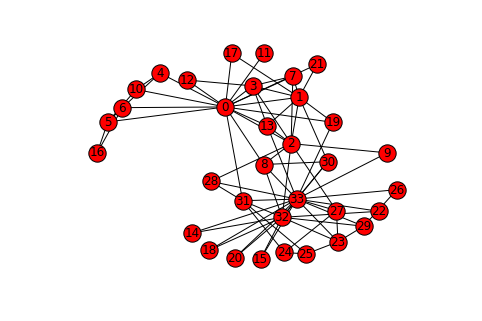

In [4]:
# Loads the karate network and stores it as a networkx graph and plots it. 

G = nx.karate_club_graph()
nx.draw_spring(G,with_labels = True)
print 'average clustering coefficient = ' + str(nx.average_clustering(G))

In [5]:
# Creates an object that tracks a Markov chain on the graph of simple graphs.

allow_loops = False
allow_multi_edges = False
is_vertex_labeled = False

graph_of_graphs = mcmc.MCMC_class(G, allow_loops, allow_multi_edges, is_vertex_labeled)

In [6]:
# This advances the Markov chain one step, and stores the current graph as G2

G2 = graph_of_graphs.step_and_get_graph()

In [7]:
# This advances the Markov chain an additional 1000 steps.

for i in xrange(0,1000):
    G2 = graph_of_graphs.step_and_get_graph()

average clustering coefficient = 0.334260424312


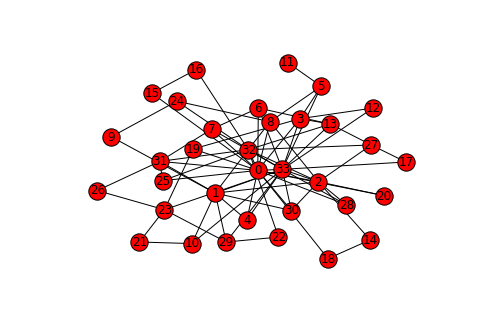

In [8]:
# Let's plot the new sampled simple graph. Notice that after 1000 MCMC steps the graph appears different.

nx.draw_spring(G2,with_labels = True)
print 'average clustering coefficient = ' + str(nx.average_clustering(G2))

In [9]:
# Let's check that the degree sequence of G2 is the same as the karate club G

print G2.degree() == G.degree()

True


In [10]:
# Let's calculate the diameter of the karate network.

print nx.diameter(G)

5


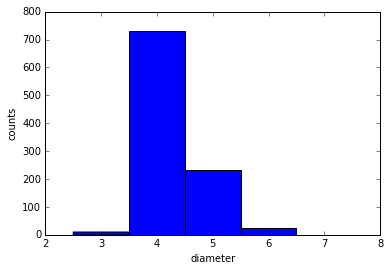

In [11]:
# Now let's find the diameter of simple graphs with the same degree sequence as Karate.
# This may take a moment. 

diameters = []
for i in xrange(0,1000):
    for j in xrange(0,1000):
        G2 = graph_of_graphs.step_and_get_graph()
    diameters.append(nx.diameter(G2))
py.hist(diameters,bins = np.linspace(2.5,7.5,6))
py.xlabel('diameter')
py.ylabel('counts')


In [12]:
# Degree assortativity (or network assortativiity) is a common network statistic used to address whether 
# high degree vertices are more or less likely to be neighbors of other high degree vertices and vice
# versa for low degree nodes. Assortativity is easy to calculate, but its not always clear how to 
# interpret the result.

karate_r = nx.degree_assortativity_coefficient(G)
print 'The karate network has assortativity = ' + str(karate_r)

The karate network has assortativity = -0.475613097685


time with networkx overhead = 8.85700011253


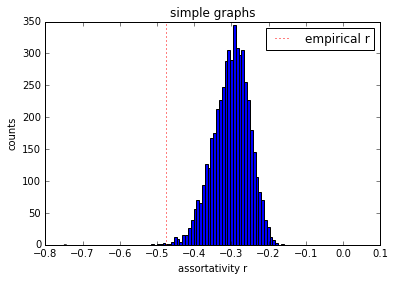

In [13]:
# Let's compare the above assortativity value to the value drawn from simple graphs with the same 
# degree sequence. Here we compare the histogram of assortativity values with the empirical value.
# For demonstration purposes we'll only take 5000 samples over 10**6 edge swaps.

import time

samples = 5000
tic = time.time()
assortativities = np.zeros(samples)
for i in xrange(0,samples):
    for j in xrange(0,200):
        G2 = graph_of_graphs.step_and_get_graph()
    assortativities[i] = nx.degree_assortativity_coefficient(G2)
print 'time with networkx overhead = ' + str(time.time()-tic)

py.hist(assortativities, bins = np.linspace(-.75,0,100))
py.plot([karate_r,karate_r],[0,350],'r:',label='empirical r')

py.xlabel('assortativity r')
py.ylabel('counts')
py.legend()
py.title('simple graphs')


time without networkx overhead = 1.15700006485


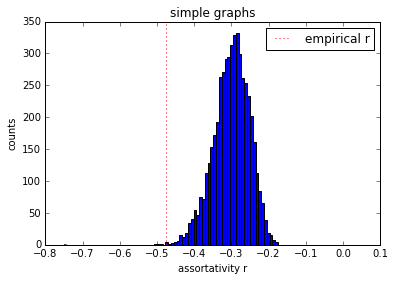

In [14]:
# The code available in sample_assortativity.py doesn't maintain a networkx graph during the MCMC process
# and is thus slightly faster than the above method utilizing MCMC_class.  Also note that sample_assortativity
# includes code to calculate assortativity on graphs with loops and multiedges.

import sample_assortativity as sa

tic = time.time()
assortativities = sa.r_sample_MCMC(G, allow_loops, allow_multi_edges, 
                                   is_vertex_labeled, its = 10**6, n_recs = 5000, filename = 'tutorial')
print 'time without networkx overhead = ' + str(time.time()-tic)

py.hist(assortativities, bins = np.linspace(-.75,0,100))
py.plot([karate_r,karate_r],[0,350],'r:',label='empirical r')

py.xlabel('assortativity r')
py.ylabel('counts')
py.legend()
py.title('simple graphs')


(-1, 1)

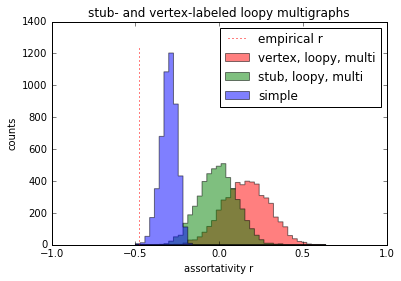

In [15]:
# The assortativities of stub- and vertex-labeled loopy multigraphs is different. Note, vertex labeled
# spaces typically require additional samples.

assortativities_vlm = sa.r_sample_MCMC(G, allow_loops = True, allow_multi = True , is_v_labeled =True,
                                     its = 10**7, n_recs = 5000, filename = 'tutorial')
assortativities_slm = sa.r_sample_MCMC(G, allow_loops = True, allow_multi = True , is_v_labeled =False,
                                     its = 10**7, n_recs = 5000, filename = 'tutorial')

py.hist([assortativities, assortativities_slm, assortativities_vlm], bins = 40, 
        label = ['simple','stub, loopy, multi','vertex, loopy, multi'], histtype = 'stepfilled', alpha = .5)
py.plot([karate_r,karate_r],[0,1250],'r:',label='empirical r')

py.xlabel('assortativity r')
py.ylabel('counts')
py.title('stub- and vertex-labeled loopy multigraphs')
py.legend()
py.xlim(-1,1)


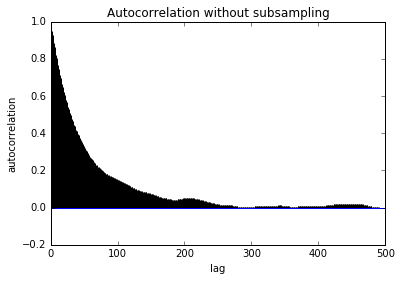

In [16]:
# One way to check that samples are approximately independent of each other is to take an autocorrelation of the sequence
# of statistics produced.  Here we produce a sequence of assortativities of simple graphs without sub sampling.
# Since we started the MCMC sampling at the empirical graph, we will exclude the first 20% of the
# sampled assortativites. (A related method, but outside of our scope, can calculate the effective sample size.)

r_no_sub_sampling = sa.r_sample_MCMC(G, allow_loops, allow_multi_edges, 
                                   is_vertex_labeled, its = 10**5, n_recs = 10**5, filename = 'tutorial_no_subsampling')

py.acorr(r_no_sub_sampling[20000::]-r_no_sub_sampling[20000::].mean(),maxlags=500,normed=True)
py.xlim(0,500)
py.xlabel('lag')
py.ylabel('autocorrelation')
py.title('Autocorrelation without subsampling')


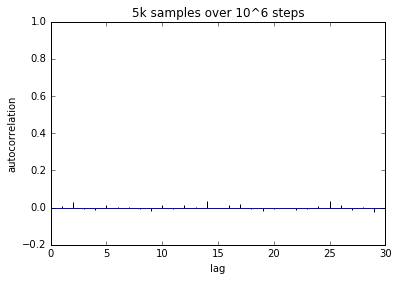

In [17]:
# In comparison, the autocorrelation of the original sampling of assortativites on simple graphs with a 200 steps
# between samples produces the following autocorrelation.

py.acorr(assortativities[1000::]-assortativities[1000::].mean(),maxlags=30,normed=True)
py.xlim(0,30)
py.xlabel('lag')
py.ylabel('autocorrelation')
py.title('5k samples over 10^6 steps')


In [18]:
r_no_sub_sampling[1000:1011]

array([-0.2338334 , -0.23695027, -0.2405124 , -0.2405124 , -0.2405124 ,
       -0.2405124 , -0.2405124 , -0.23605973, -0.24140293, -0.24140293,
       -0.24140293])

Testing sampling with selfloops= False multi_edges= False
number of graphs visited: 7
Testing sampling with selfloops= False multi_edges= False
number of graphs visited: 7
Testing sampling with selfloops= False multi_edges= True
number of graphs visited: 10
Testing sampling with selfloops= False multi_edges= True
number of graphs visited: 10
Testing sampling with selfloops= True multi_edges= False
number of graphs visited: 17
Testing sampling with selfloops= True multi_edges= False
number of graphs visited: 17
Testing sampling with selfloops= True multi_edges= True
number of graphs visited: 23
Testing sampling with selfloops= True multi_edges= True
number of graphs visited: 23


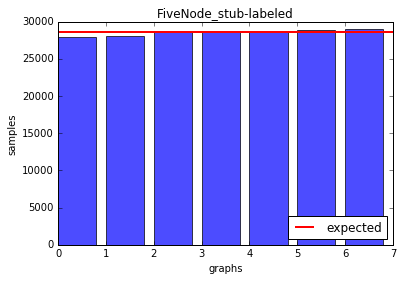

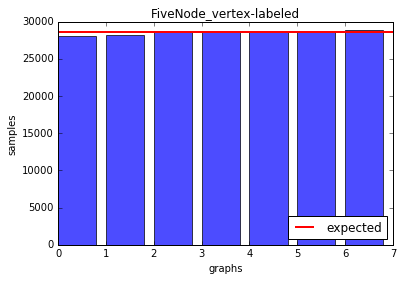

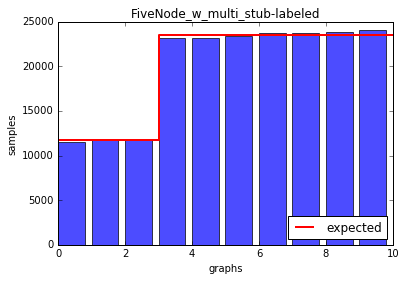

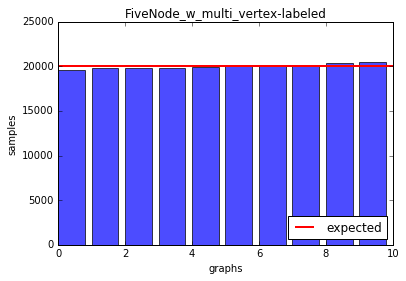

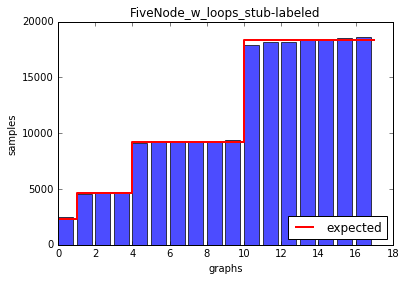

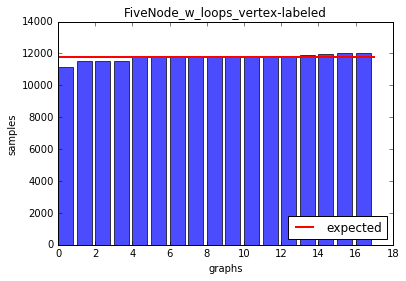

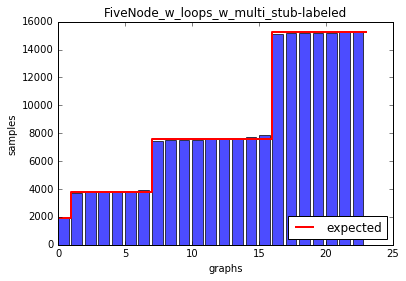

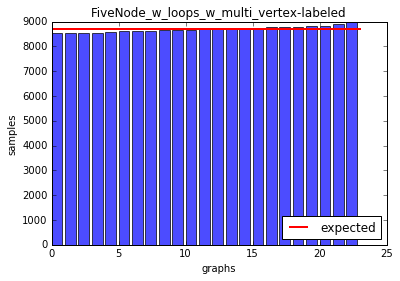

In [19]:
# For those interested in double checking the uniformity of the MCMC sampler, the module dist_verification 
# contains methods for this. test_sampling_five_nodes creates a small test graph with deg seq [1,2,2,2,1] 
# and creates a histogram of the number of times each adj matrix is visited. Output is saved in the verification
# sub directory. A more thorough test is implemented in test_sampling_seven_node.

import dist_verification as dv

dv.test_sampling_five_node()

This concludes the tutorial. 